In [1]:
import pandas as pd
import csv

labeled_corpus = pd.read_csv('labeled_corpus.csv', encoding = 'utf-8', index_col = [0])
labeled_corpus = labeled_corpus[labeled_corpus['token_ngram'].notna()]

In [2]:
import numpy as np
from sklearn.pipeline import Pipeline

In [3]:
labeled_corpus

,token_ngram,label
0,"들/VV,국제/NNG,유가/NNG,크/VA,오르/VV,원화/NNG,엔/NNG,화간/...",-1
1,"위안/NNG,절상/NNG,원화/NNG,절상/NNG,가장/MAG,크/VA,추가/NNG...",1
2,"금융/NNG,불안사태/NNG,발생/NNG,하/VV,가운데/NNG,국제/NNG,환투기...",0
3,"금리갭/NNG,확대/NNG,되/XSV,가운데/NNG,남/VV,fed/NNG,금리/N...",1
4,"미/NNG,달러/NNG,엔/NNG,약세/NNG,지속/NNG,되/VV,보/VV,물/V...",0
...,...,...
256264,"경기/NNG,전망/NNG,비교적/VAX,분명/MAG,인플레이션/NNG,명분/NNG,...",-1
256265,"믹스/NNG,합의/NNG,반영/NNG,예상/NNG,경제/NNG,성장률/NNG,하향/...",0
256266,"돌아온/VV,박스권/NNG,하단/NNG,상단/NNG,테스트/NNG,가능성/NNG,무...",0
256267,"돌아온/VV,박스권/NNG,하단/NNG,상단/NNG,테스트/NNG,가능성/NNG,무...",1


In [4]:
labeled_corpus = labeled_corpus[labeled_corpus['label']!= 0]
labeled_corpus

,token_ngram,label
0,"들/VV,국제/NNG,유가/NNG,크/VA,오르/VV,원화/NNG,엔/NNG,화간/...",-1
1,"위안/NNG,절상/NNG,원화/NNG,절상/NNG,가장/MAG,크/VA,추가/NNG...",1
3,"금리갭/NNG,확대/NNG,되/XSV,가운데/NNG,남/VV,fed/NNG,금리/N...",1
5,"들/VV,달러/NNG,엔/NNG,유로/NNG,대해/VV,상당히/MAG,강세/NNG,...",1
7,"자본/NNG,유입/NNG,대해서/VV,관대/NNG,반면/NNG,자본/NNG,유출/N...",1
...,...,...
256262,"가/VV,채권투자/NNG,채권시장/NNG,전망/NNG,금융시장/NNG,차/NNG,트...",-1
256263,"fed/NNG,원자재/NNG,가격/NNG,상승/NNG,둔화/NNG,여부/NNG,관심...",-1
256264,"경기/NNG,전망/NNG,비교적/VAX,분명/MAG,인플레이션/NNG,명분/NNG,...",-1
256267,"돌아온/VV,박스권/NNG,하단/NNG,상단/NNG,테스트/NNG,가능성/NNG,무...",1


In [18]:
labeled_corpus.to_csv('final_corpus_without_0.csv', encoding = 'utf-8')


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm

In [7]:
def my_tokenizer(x):
    return x.split(",")

In [23]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,1), min_df = 15, tokenizer = my_tokenizer)),
                      ('clf', MultinomialNB(alpha=0.001)), ])
clf = text_clf.named_steps['clf']



In [24]:
#Bagging
avg_polarity_score = np.zeros((1, 18787))
for i in tqdm(range(30)):
    X_train, X_test, y_train, y_test = train_test_split(labeled_corpus['token_ngram'], labeled_corpus['label'], random_state = 0, train_size = 0.9, shuffle=True)
    text_clf.fit(X_train, y_train)
    posterior = clf.feature_log_prob_
    polarity_score = posterior[1]/posterior[0]
    
    avg_polarity_score += polarity_score
    
avg_polarity_score = avg_polarity_score/30




  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


  3%|██▊                                                                                | 1/30 [00:13<06:24, 13.26s/it]


  7%|█████▌                                                                             | 2/30 [00:26<06:12, 13.29s/it]


 10%|████████▎                                                                          | 3/30 [00:39<05:58, 13.28s/it]


 13%|███████████                                                                        | 4/30 [00:53<05:45, 13.30s/it]


 17%|█████████████▊                                                                     | 5/30 [01:06<05:33, 13.35s/it]


 20%|████████████████▌                                                                  | 6/30 [01:20<05:20, 13.37s/it]


 23%|███████████████████▎                                                               | 7/30 [01:33<05:07, 13.35s/it]


 27%|████████████████

([array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0.

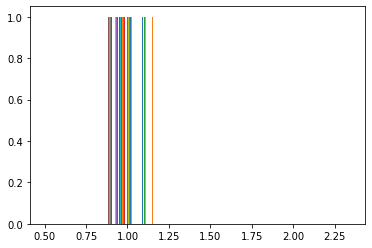

In [28]:
import matplotlib.pyplot as plt
plt.hist(avg_polarity_score)

In [ ]:
lf.class